# Community Detection and Relationship Analysis for Glossary Terms Using the Leiden Algorithm

Description:

This notebook demonstrates how to use the Leiden algorithm to detect communities within a glossary of legal terms and analyze relationships between them. The glossary terms are grouped into distinct communities based on their interconnections, providing insights into how terms are related and clustered around specific themes or legal processes.

The notebook is structured as follows:

- Leiden Community Detection: We apply the Leiden algorithm to the glossary terms to uncover communities of closely related terms. Each term is assigned to a community, helping users understand which terms are more related to each other based on their relationships.

- Exploration of Communities: Users can explore which terms belong to the same community, compare different communities, and identify key terms within each group. This helps in clustering glossary terms that share similar legal contexts or processes.

- Relationship Queries: We provide pre-built Cypher queries to explore direct relationships between terms, such as finding related terms, counting relationships, and identifying central terms in a community.

- Graph Algorithms: Additional graph algorithms, such as PageRank, are used to highlight the most important terms based on their connections within the graph.

Benefits:

- Thematic Clustering: The Leiden algorithm reveals which glossary terms naturally group together, helping users better understand legal topics and their relationships.
  - Graph Exploration: The notebook provides tools to navigate the graph of glossary terms, discover related terms, and explore the structure of legal concepts.
  - Community Detection: By detecting communities, the user can identify clusters of terms, which may represent stages in legal processes or thematic groupings of legal terms.

This notebook is a powerful tool for analyzing glossary terms, making it easier to understand their relationships, navigate complex legal concepts, and identify important terms.

In [80]:
import os
from langchain_community.graphs import Neo4jGraph
from langchain_community.vectorstores import Neo4jVector
import pprint

In [2]:
NEO4J_URI = "bolt://localhost:7687"

In [3]:
NEO4J_URI = 'bolt://' + os.getenv('NEO4J_HOST') + ':7687'
NEO4J_USERNAME = os.getenv('NEO4J_USER')
NEO4J_PASSWORD = os.getenv('NEO4J_PASSWORD')
NEO4J_DATABASE = 'neo4j' #os.getenv('NEO4J_DB')
print(NEO4J_URI)
print(NEO4J_DATABASE)

bolt://neo4j:7687
neo4j


In [4]:
kg = Neo4jGraph(
    url=NEO4J_URI, username=NEO4J_USERNAME, password=NEO4J_PASSWORD, database=NEO4J_DATABASE
)

In [5]:
cypher_get_glossary = """
MATCH (n:UpdatedChunk) where n.type='glossary' return n.glossaryTerm as  glossaryTerm, n.text as Text
"""

In [9]:
glossary = kg.query(cypher_get_glossary)

In [10]:
print(len(glossary))

67


In [11]:
for glossary in glossaries:
    print(glossary['glossaryTerm'])

Act
Adjournment
Amendment
Amended Bill
Amending Bill
Amending Regulation
Annual Bound Statutes (Buckram Bound, hardcover)
Bill
Bill Stages
Cabinet
Chapter Numbers
Citation
Coming into force
Commencement Section
Committee
Committee of the Whole House
Consequential Amendment
Consolidated Provisions in Force
Consolidated Regulations of British Columbia
Consolidated Statutes of British Columbia ('the Looseleaf')
Consolidation Period
Corporate Registry
Current Unofficial Consolidation
Dissolution
Enact
Executive Council
First Reading
First Reading Bill
Gazette
Hansard
Historical Note
Historical Supreme Court Rules
House
Legislative Assembly
Legislature
Lieutenant Governor
Lieutenant Governor in Council
Looseleaf
Minister of Finance full-text Directives and Resumes
MLA
Motion
Official Version
Order, Order in Council, Ministerial Order
Parliament
Point in Time (PIT)
Proclamation
Prorogation
Provision
Provisions in Force
Regulation
Regulations Bulletins
Repealed
Report Bill
Revision
Royal Asse

In [88]:
check_gds = """
RETURN gds.version();
"""

In [89]:
kg.query(check_gds)

[{'gds.version()': '2.9.0'}]

## Proejct the graph into memory

In [23]:
drop_projected_graph = """
CALL gds.graph.drop('myGraph')
"""

In [ ]:
kg.query(drop_projected_graph)

In [25]:
myGraph = """
MATCH (source:UpdatedChunk)-[r:RELATED_TERMS]->(target:UpdatedChunk)
RETURN gds.graph.project(
  'myGraph',
  source,
  target,
  {

  },
  { undirectedRelationshipTypes: ['*'] }
)
  """

In [26]:
kg.query(myGraph)

[{"gds.graph.project(\n  'myGraph',\n  source,\n  target,\n  {\n\n  },\n  { undirectedRelationshipTypes: ['*'] }\n)": {'relationshipCount': 134,
   'graphName': 'myGraph',
   'query': "\nMATCH (source:UpdatedChunk)-[r:RELATED_TERMS]->(target:UpdatedChunk)\nRETURN gds.graph.project(\n  'myGraph',\n  source,\n  target,\n  {\n\n  },\n  { undirectedRelationshipTypes: ['*'] }\n)\n  ",
   'projectMillis': 1547,
   'configuration': {'readConcurrency': 4,
    'undirectedRelationshipTypes': ['*'],
    'jobId': '184fe786-0385-46e5-bb6a-97e843e03ec8',
    'logProgress': True,
    'query': "\nMATCH (source:UpdatedChunk)-[r:RELATED_TERMS]->(target:UpdatedChunk)\nRETURN gds.graph.project(\n  'myGraph',\n  source,\n  target,\n  {\n\n  },\n  { undirectedRelationshipTypes: ['*'] }\n)\n  ",
    'inverseIndexedRelationshipTypes': [],
    'creationTime': neo4j.time.DateTime(2024, 10, 25, 15, 57, 12, 765643495, tzinfo=<UTC>)},
   'nodeCount': 42}}]

In [27]:
graph_memory_estimate = """
CALL gds.leiden.write.estimate('myGraph', {writeProperty: 'communityId', randomSeed: 19})
YIELD nodeCount, relationshipCount, requiredMemory
"""

In [28]:
kg.query(graph_memory_estimate)

[{'nodeCount': 42,
  'relationshipCount': 134,
  'requiredMemory': '[559 KiB ... 560 KiB]'}]

### ### Show the commnuity after the aglorithim has completed

In [29]:
stream_leiden = """
CALL gds.leiden.stream('myGraph')
YIELD nodeId, communityId
RETURN gds.util.asNode(nodeId).glossaryTerm AS name, communityId
ORDER BY name ASC
"""

In [30]:
kg.query(stream_leiden)

[{'name': 'Act', 'communityId': 14},
 {'name': 'Adjournment', 'communityId': 11},
 {'name': 'Amended Bill', 'communityId': 2},
 {'name': 'Amending Bill', 'communityId': 14},
 {'name': 'Amending Regulation', 'communityId': 14},
 {'name': 'Amendment', 'communityId': 9},
 {'name': 'Annual Bound Statutes (Buckram Bound, hardcover)',
  'communityId': 7},
 {'name': 'Bill', 'communityId': 8},
 {'name': 'Bill Stages', 'communityId': 8},
 {'name': 'Cabinet', 'communityId': 1},
 {'name': 'Chapter Numbers', 'communityId': 14},
 {'name': 'Coming into force', 'communityId': 10},
 {'name': 'Commencement Section', 'communityId': 10},
 {'name': 'Committee', 'communityId': 8},
 {'name': 'Committee of the Whole House', 'communityId': 8},
 {'name': 'Consequential Amendment', 'communityId': 9},
 {'name': 'Consolidated Provisions in Force', 'communityId': 3},
 {'name': 'Consolidated Regulations of British Columbia', 'communityId': 7},
 {'name': "Consolidated Statutes of British Columbia ('the Looseleaf')",

In [31]:
test = """
CALL gds.pageRank.stream('myGraph')
YIELD nodeId, score
RETURN gds.util.asNode(nodeId).glossaryTerm AS name, score
ORDER BY score DESC
LIMIT 10
"""
kg.query(test)

[{'name': 'Official Version', 'score': 2.569884481094245},
 {'name': 'Bill Stages', 'score': 1.7573752355218164},
 {'name': 'Act', 'score': 1.6551578717726698},
 {'name': 'Consolidated Regulations of British Columbia',
  'score': 1.5920024447829655},
 {'name': 'Bill', 'score': 1.515237809744991},
 {'name': 'Royal Assent', 'score': 1.402891495173952},
 {'name': 'First Reading', 'score': 1.2780644314435003},
 {'name': 'Second Reading', 'score': 1.2780644314435003},
 {'name': 'Third Reading', 'score': 1.2780644314435003},
 {'name': 'Report Bill', 'score': 1.1804109542486736}]

In [32]:
test = """
CALL gds.leiden.stats('myGraph', { randomSeed: 19 })
YIELD communityCount
"""
kg.query(test)

[{'communityCount': 11}]

## Intermediate Communities

In [81]:
test = """
CALL gds.leiden.stream('myGraph', {
  randomSeed: 23,
  includeIntermediateCommunities: true,
  concurrency: 1
})
YIELD nodeId, communityId, intermediateCommunityIds
RETURN gds.util.asNode(nodeId).glossaryTerm AS name, communityId, intermediateCommunityIds
ORDER BY name ASC
"""
data = kg.query(test)
pprint.pprint(data)

[{'communityId': 12, 'intermediateCommunityIds': [41, 12], 'name': 'Act'},
 {'communityId': 13,
  'intermediateCommunityIds': [4, 13],
  'name': 'Adjournment'},
 {'communityId': 8,
  'intermediateCommunityIds': [32, 8],
  'name': 'Amended Bill'},
 {'communityId': 12,
  'intermediateCommunityIds': [41, 12],
  'name': 'Amending Bill'},
 {'communityId': 12,
  'intermediateCommunityIds': [9, 12],
  'name': 'Amending Regulation'},
 {'communityId': 2, 'intermediateCommunityIds': [25, 2], 'name': 'Amendment'},
 {'communityId': 4,
  'intermediateCommunityIds': [11, 4],
  'name': 'Annual Bound Statutes (Buckram Bound, hardcover)'},
 {'communityId': 10, 'intermediateCommunityIds': [12, 10], 'name': 'Bill'},
 {'communityId': 10,
  'intermediateCommunityIds': [12, 10],
  'name': 'Bill Stages'},
 {'communityId': 11, 'intermediateCommunityIds': [17, 11], 'name': 'Cabinet'},
 {'communityId': 12,
  'intermediateCommunityIds': [41, 12],
  'name': 'Chapter Numbers'},
 {'communityId': 0,
  'intermediateC

## Write the data back to the original node

### Write intermeidate community

In [76]:
write_intermediate_community = """
CALL gds.leiden.write('myGraph', {
  writeProperty: 'intermediateCommunities',
  randomSeed: 19,
  includeIntermediateCommunities: true,
  concurrency: 1
})
YIELD communityCount, modularity, modularities
"""

In [75]:
kg.query(write_intermediate_community)

[{'communityCount': 11,
  'modularity': 0.715860993539764,
  'modularities': [0.6697482735575851, 0.715860993539764]}]

### write final commuity id

In [72]:
write_community = """
CALL gds.leiden.write('myGraph', {
    writeProperty: 'communityId',                           // Final communities
    randomSeed: 19,
    concurrency: 1
})
YIELD communityCount, modularity, modularities
"""

In [73]:
kg.query(write_community)

[{'communityCount': 11,
  'modularity': 0.715860993539764,
  'modularities': [0.6697482735575851, 0.715860993539764]}]

In [74]:
cypher = """
MATCH (n:UpdatedChunk)
RETURN n.communityId as finalCommunity,
       n.intermediateCommunities as intermediateCommunity
LIMIT 5
"""
kg.query(cypher)

[{'finalCommunity': None, 'intermediateCommunity': None},
 {'finalCommunity': None, 'intermediateCommunity': None},
 {'finalCommunity': None, 'intermediateCommunity': None},
 {'finalCommunity': None, 'intermediateCommunity': None},
 {'finalCommunity': None, 'intermediateCommunity': None}]

## Now lets try to understnad what kind of questions this graph can help answer

### Querying the nodes and their community ID's from teh saved Node in NEO4J

In [40]:
query = """
MATCH (n:UpdatedChunk)
where n.communityId is not NULL
RETURN n.glossaryTerm AS Term, n.communityId
ORDER BY n.communityId
"""

In [41]:
kg.query(query)

[{'Term': 'Annual Bound Statutes (Buckram Bound, hardcover)',
  'n.communityId': 1},
 {'Term': 'Consolidated Regulations of British Columbia', 'n.communityId': 1},
 {'Term': "Consolidated Statutes of British Columbia ('the Looseleaf')",
  'n.communityId': 1},
 {'Term': 'Current Unofficial Consolidation', 'n.communityId': 1},
 {'Term': 'Gazette', 'n.communityId': 1},
 {'Term': 'Historical Note', 'n.communityId': 1},
 {'Term': 'Looseleaf', 'n.communityId': 1},
 {'Term': 'Official Version', 'n.communityId': 1},
 {'Term': 'Amendment', 'n.communityId': 3},
 {'Term': 'Consequential Amendment', 'n.communityId': 3},
 {'Term': 'Coming into force', 'n.communityId': 4},
 {'Term': 'Commencement Section', 'n.communityId': 4},
 {'Term': 'Royal Assent', 'n.communityId': 4},
 {'Term': 'Revision', 'n.communityId': 5},
 {'Term': 'R.S.B.C.', 'n.communityId': 5},
 {'Term': 'Parliament', 'n.communityId': 6},
 {'Term': 'Session', 'n.communityId': 6},
 {'Term': 'Sitting', 'n.communityId': 6},
 {'Term': 'Cons

### Find All Nodes in a Specific Community:

In [166]:
query = """
MATCH (n:UpdatedChunk)
WHERE n.communityId = 10
RETURN n.glossaryTerm AS Term
"""

In [167]:
kg.query(query)

[{'Term': 'Adjournment'}, {'Term': 'Dissolution'}, {'Term': 'Prorogation'}]

### What communities exist and what terms are in each

In [38]:
query = """
MATCH (n:UpdatedChunk)
where n.communityId is not null
RETURN n.communityId AS communityId, COLLECT(n.glossaryTerm) AS terms
"""

In [39]:
kg.query(query)

[{'communityId': 12,
  'terms': ['Act',
   'Amending Bill',
   'Amending Regulation',
   'Chapter Numbers',
   'Regulation',
   'Statute']},
 {'communityId': 10, 'terms': ['Adjournment', 'Dissolution', 'Prorogation']},
 {'communityId': 3, 'terms': ['Amendment', 'Consequential Amendment']},
 {'communityId': 9,
  'terms': ['Amended Bill',
   'First Reading Bill',
   'Report Bill',
   'Third Reading Bill']},
 {'communityId': 1,
  'terms': ['Annual Bound Statutes (Buckram Bound, hardcover)',
   'Consolidated Regulations of British Columbia',
   "Consolidated Statutes of British Columbia ('the Looseleaf')",
   'Current Unofficial Consolidation',
   'Gazette',
   'Historical Note',
   'Looseleaf',
   'Official Version']},
 {'communityId': 13,
  'terms': ['Bill',
   'Bill Stages',
   'Committee',
   'Committee of the Whole House',
   'First Reading',
   'Second Reading',
   'Third Reading']},
 {'communityId': 14, 'terms': ['Cabinet', 'Executive Council']},
 {'communityId': 4,
  'terms': ['Com

### Which glossary term is the central node in its community?"
If you want to find a "central" node in a community (using centrality or relationships count):

In [36]:
query = """
MATCH (n:UpdatedChunk)-[r:RELATED_TERMS]->()
where n.communityId is NOT NULL
WITH n, COUNT(r) AS degree
RETURN n.glossaryTerm, n.communityId, degree
ORDER BY degree DESC
"""

In [37]:
kg.query(query)

[{'n.glossaryTerm': 'Bill', 'n.communityId': 13, 'degree': 4},
 {'n.glossaryTerm': 'Bill Stages', 'n.communityId': 13, 'degree': 4},
 {'n.glossaryTerm': 'First Reading', 'n.communityId': 13, 'degree': 4},
 {'n.glossaryTerm': 'Second Reading', 'n.communityId': 13, 'degree': 4},
 {'n.glossaryTerm': 'Third Reading', 'n.communityId': 13, 'degree': 4},
 {'n.glossaryTerm': 'Consolidated Regulations of British Columbia',
  'n.communityId': 1,
  'degree': 3},
 {'n.glossaryTerm': 'First Reading Bill', 'n.communityId': 9, 'degree': 3},
 {'n.glossaryTerm': 'Report Bill', 'n.communityId': 9, 'degree': 3},
 {'n.glossaryTerm': 'Third Reading Bill', 'n.communityId': 9, 'degree': 3},
 {'n.glossaryTerm': 'Act', 'n.communityId': 12, 'degree': 2},
 {'n.glossaryTerm': 'Adjournment', 'n.communityId': 10, 'degree': 2},
 {'n.glossaryTerm': 'Amending Bill', 'n.communityId': 12, 'degree': 2},
 {'n.glossaryTerm': 'Amending Regulation', 'n.communityId': 12, 'degree': 2},
 {'n.glossaryTerm': 'Chapter Numbers', 'n

### "How many terms reference 'Bill'?"
This query counts the number of terms related to "Bill":

In [180]:
query = """
MATCH (n:UpdatedChunk {glossaryTerm: 'Bill'})-[:RELATED_TERMS]->(related)
RETURN COUNT(related)
"""

In [181]:
kg.query(query)

[{'COUNT(related)': 4}]

## Finding relationships
"Which terms reference both 'Second Reading' and 'Bill'?"

To find terms that are related to both "Amendment" and "Bill":

In [184]:
query = """
MATCH (n:UpdatedChunk)-[:RELATED_TERMS]->(a:UpdatedChunk {glossaryTerm: 'Second Reading'}),
      (n)-[:RELATED_TERMS]->(b:UpdatedChunk {glossaryTerm: 'Bill'})
RETURN n.glossaryTerm
"""

In [185]:
kg.query(query) 

[{'n.glossaryTerm': 'Bill Stages'}]

## Visulaizing the graph that has all related terms (nothing to do with this community detection)
- Run this on the NEO4J browser

In [155]:
query = """
MATCH (n:UpdatedChunk)-[r:RELATED_TERMS]->(m:UpdatedChunk)
RETURN n, r, m
"""

In [ ]:
kg.query(query)

## Summarizing Communities and Terms:

"How many terms are there in each community?"

In [191]:
query = """
MATCH (n:UpdatedChunk)
where n.communityId is not null
RETURN n.communityId AS communityId, COUNT(n) AS term_count
"""

In [192]:
kg.query(query)

[{'communityId': 12, 'term_count': 6},
 {'communityId': 10, 'term_count': 3},
 {'communityId': 3, 'term_count': 2},
 {'communityId': 9, 'term_count': 4},
 {'communityId': 1, 'term_count': 8},
 {'communityId': 13, 'term_count': 7},
 {'communityId': 14, 'term_count': 2},
 {'communityId': 4, 'term_count': 3},
 {'communityId': 8, 'term_count': 2},
 {'communityId': 6, 'term_count': 3},
 {'communityId': 5, 'term_count': 2}]

Which community has the most terms?"

In [194]:
query = """
MATCH (n:UpdatedChunk)
where n.communityId is not NULL
RETURN n.communityId AS communityId, COUNT(n) AS term_count
ORDER BY term_count DESC
LIMIT 1
"""

In [195]:
kg.query(query)

[{'communityId': 1, 'term_count': 8}]

"What is the largest community by number of terms?"

In [196]:
query = """
MATCH (n:UpdatedChunk)
where n.communityId is not NULL
RETURN n.communityId AS communityId, COUNT(n) AS community_size
ORDER BY community_size DESC
LIMIT 1
"""

In [197]:
kg.query(query)

[{'communityId': 1, 'community_size': 8}]

## Visualizing these communities

In [ ]:
!pip install seaborn

In [108]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
import numpy as np
import json
from collections import defaultdict
import pandas as pd
import plotly.graph_objects as go
import networkx as nx
from collections import defaultdict

In [109]:
data[0]

{'name': 'Act', 'communityId': 12, 'intermediateCommunityIds': [41, 12]}

In [110]:
# Approach 1: Create separate columns for each intermediate community
def transform_data_separate_columns(data):
    df = pd.DataFrame(data)
    # Split intermediate communities into separate columns
    df[['intermediate_community_1', 'intermediate_community_2']] = pd.DataFrame(
        df['intermediateCommunityIds'].tolist(), 
        index=df.index
    )
    return df

In [111]:
df = transform_data_separate_columns(data)

In [112]:
def create_sankey_diagram(df):
    # Create source, target, and value lists for Sankey diagram
    source = []
    target = []
    value = []
    labels = []
    
    # Create a mapping of unique community IDs to continuous indices
    intermediate_communities = set(x[0] for x in df['intermediateCommunityIds'])
    final_communities = set(df['communityId'])
    all_communities = list(intermediate_communities) + list(final_communities)
    community_to_index = {comm: idx for idx, comm in enumerate(all_communities)}
    
    # Add suffix to distinguish between stages
    intermediate_labels = [f"Int_{x}" for x in intermediate_communities]
    final_labels = [f"Final_{x}" for x in final_communities]
    labels = intermediate_labels + final_labels
    
    # Count transitions
    transitions = defaultdict(int)
    for _, row in df.iterrows():
        intermediate = row['intermediateCommunityIds'][0]
        final = row['communityId']
        transitions[(intermediate, final)] += 1
    
    # Create Sankey data
    for (source_comm, target_comm), count in transitions.items():
        source.append(community_to_index[source_comm])
        target.append(community_to_index[target_comm])
        value.append(count)
    
    # Create figure
    fig = go.Figure(data=[go.Sankey(
        node=dict(
            pad=15,
            thickness=20,
            line=dict(color="black", width=0.5),
            label=labels,
            color="lightblue"
        ),
        link=dict(
            source=source,
            target=target,
            value=value
        )
    )])
    
    # Update layout
    fig.update_layout(
        title_text="Community Evolution: Intermediate → Final",
        font_size=10,
        height=800
    )
    
    return fig

In [120]:
def create_community_summary(df):
    """Create summary statistics for communities"""
    # Extract first intermediate community IDs and get unique values
    intermediate_ids = df['intermediateCommunityIds'].apply(lambda x: x[0]).unique()
    
    # Summary for intermediate communities
    intermediate_summary = pd.DataFrame([
        {'stage': 'Intermediate', 
         'community': x, 
         'size': len(df[df['intermediateCommunityIds'].apply(lambda y: y[0] == x)])}
        for x in intermediate_ids
    ])
    
    # Summary for final communities
    final_summary = pd.DataFrame([
        {'stage': 'Final', 
         'community': x, 
         'size': len(df[df['communityId'] == x])}
        for x in df['communityId'].unique()
    ])
    
    return pd.concat([intermediate_summary, final_summary])


Community Summary Statistics:
--------------------------------------------------
Number of intermediate communities: 14
Number of final communities: 11


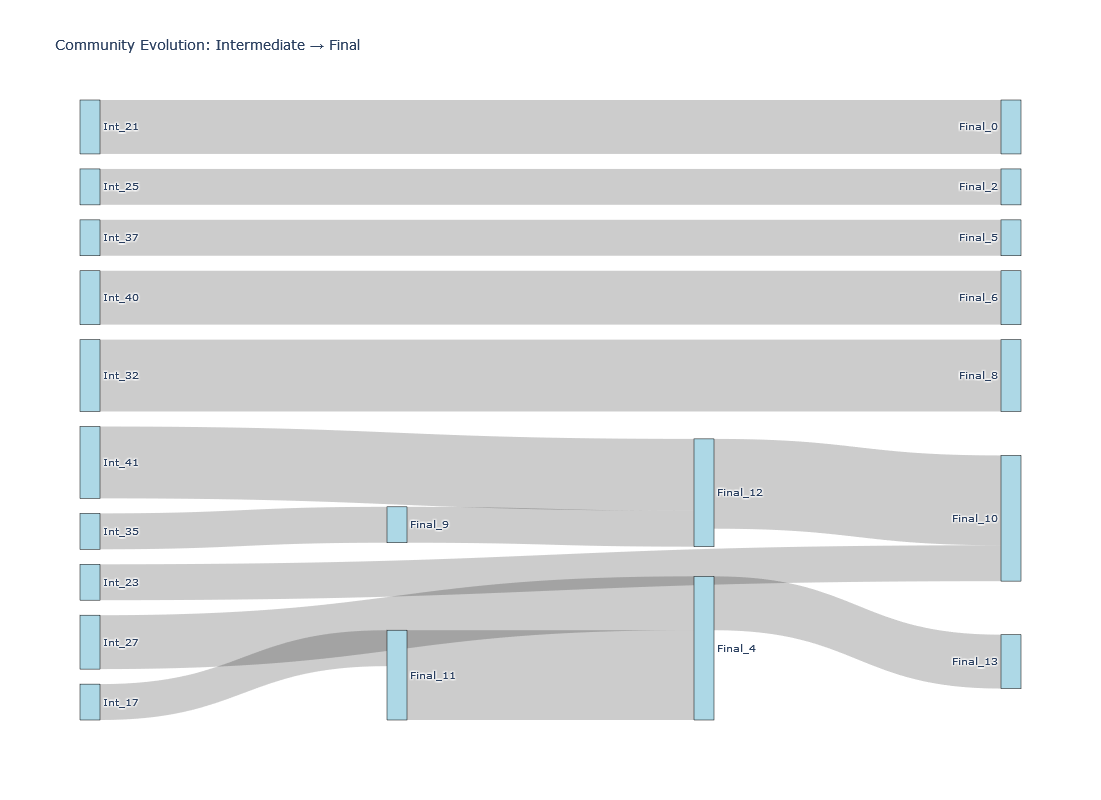


Nodes that changed communities:
                                                 Node  Intermediate Community  \
0                                                 Act                      41   
1                                         Adjournment                       4   
2                                        Amended Bill                      32   
3                                       Amending Bill                      41   
4                                 Amending Regulation                       9   
5                                           Amendment                      25   
6    Annual Bound Statutes (Buckram Bound, hardcover)                      11   
7                                                Bill                      12   
8                                         Bill Stages                      12   
9                                             Cabinet                      17   
10                                    Chapter Numbers                      4

In [121]:
# Create visualizations
sankey_fig = create_sankey_diagram(df)
summary_df = create_community_summary(df)

# Display summary statistics
print("\nCommunity Summary Statistics:")
print("-" * 50)
print(f"Number of intermediate communities: {len(df['intermediateCommunityIds'].apply(lambda x: x[0]).unique())}")
print(f"Number of final communities: {len(df['communityId'].unique())}")

# Create detailed view of node assignments
def create_node_assignments_table(df):
    """Create a formatted table of node assignments"""
    assignments = []
    for _, row in df.iterrows():
        assignments.append({
            'Node': row['name'],
            'Intermediate Community': row['intermediateCommunityIds'][0],
            'Final Community': row['communityId'],
            'Changed Community': row['intermediateCommunityIds'][0] != row['communityId']
        })
    return pd.DataFrame(assignments).sort_values('Node')

node_assignments = create_node_assignments_table(df)

# Display Plotly figure
sankey_fig.show()

# Display summary statistics
print("\nNodes that changed communities:")
changed_nodes = node_assignments[node_assignments['Changed Community']]
print(changed_nodes[['Node', 'Intermediate Community', 'Final Community']])

In [122]:
summary_df

,stage,community,size
0,Intermediate,41,4
1,Intermediate,4,3
2,Intermediate,32,4
3,Intermediate,9,2
4,Intermediate,25,2
5,Intermediate,11,5
6,Intermediate,12,5
7,Intermediate,17,2
8,Intermediate,21,3
9,Intermediate,23,2


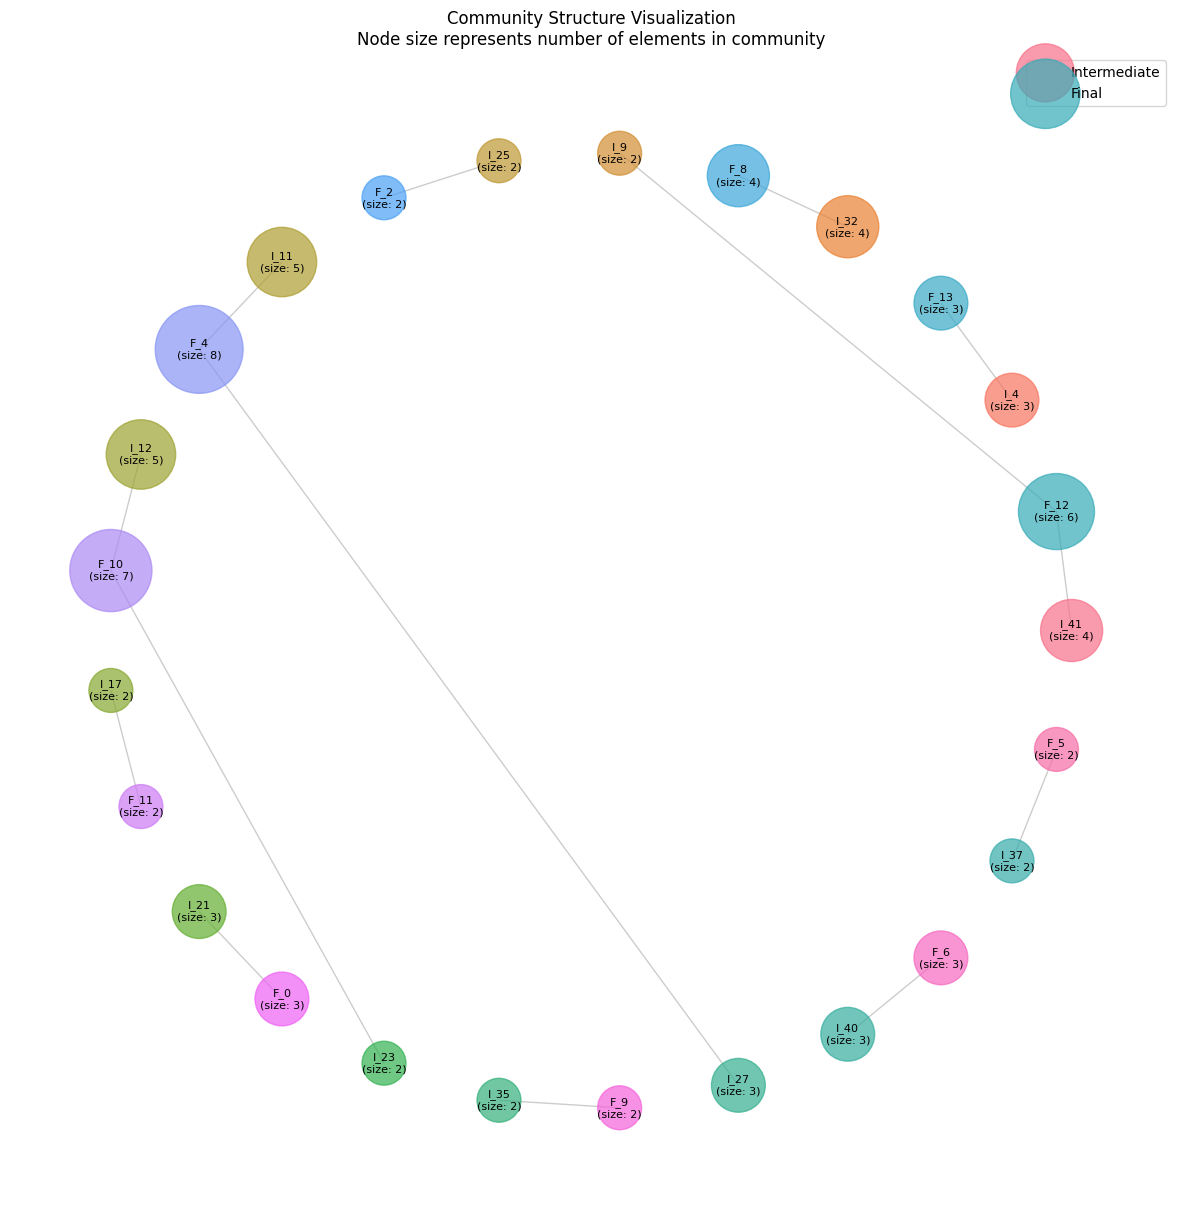

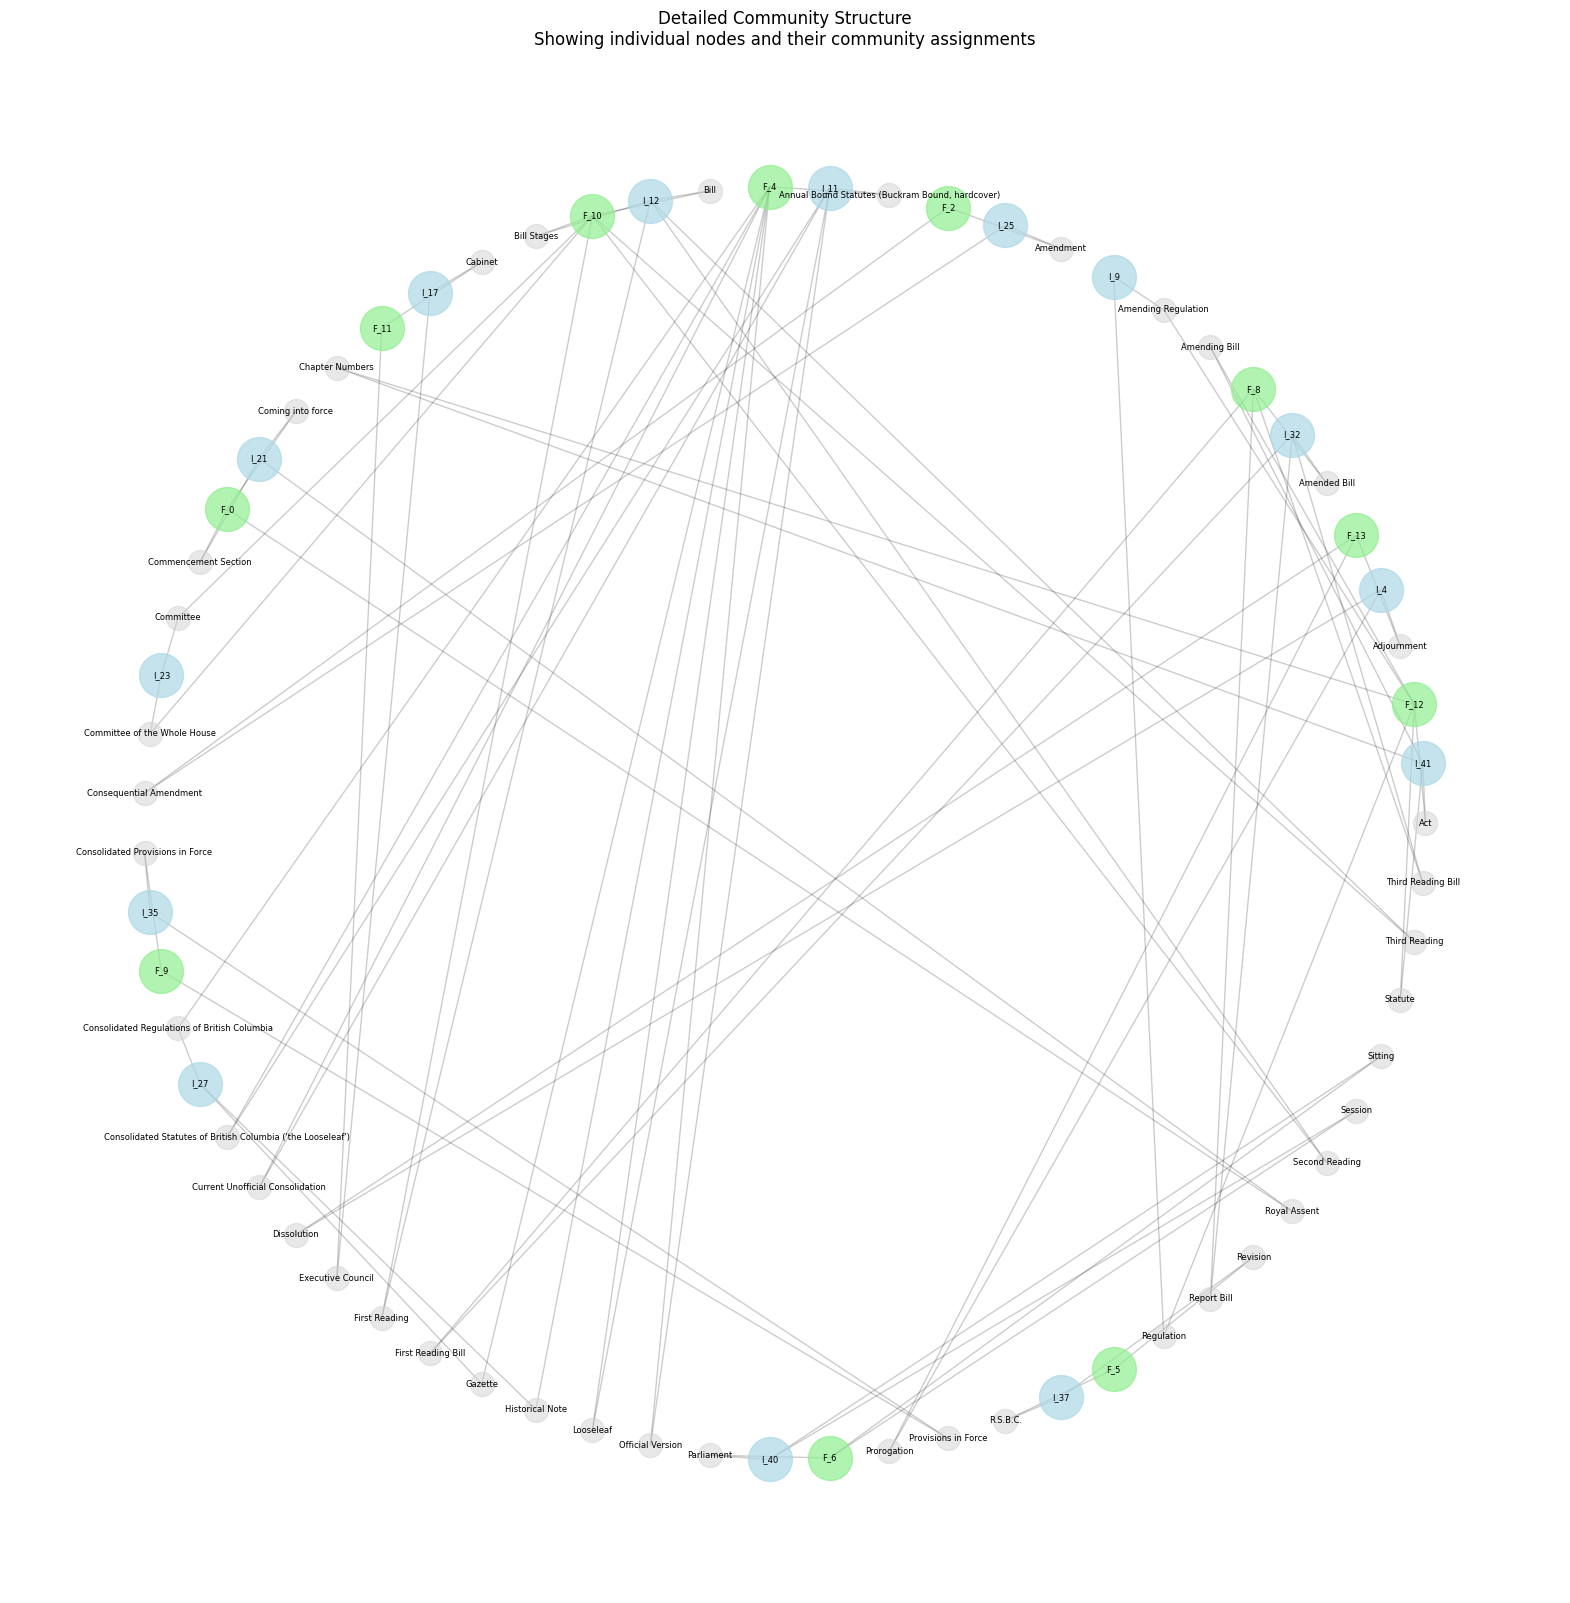


Community Summary:
--------------------------------------------------
Total nodes: 42
Intermediate communities: 14
Final communities: 11


In [123]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from collections import defaultdict
import seaborn as sns

def create_circular_community_viz(data, figsize=(15, 15)):
    """
    Create a circular visualization of communities with connections between intermediate and final stages.
    
    Args:
        data: List of dictionaries containing community data
        figsize: Tuple specifying figure size
    """
    # Convert data to DataFrame if it isn't already
    df = pd.DataFrame(data) if not isinstance(data, pd.DataFrame) else data
    
    # Create a graph
    G = nx.Graph()
    
    # Count nodes in each community
    intermediate_counts = defaultdict(int)
    final_counts = defaultdict(int)
    
    for _, row in df.iterrows():
        intermediate_id = row['intermediateCommunityIds'][0]  # Using first intermediate stage
        final_id = row['communityId']
        intermediate_counts[f"I_{intermediate_id}"] += 1
        final_counts[f"F_{final_id}"] += 1
        
        # Add edge between intermediate and final community
        G.add_edge(f"I_{intermediate_id}", f"F_{final_id}")
    
    # Set up the plot
    plt.figure(figsize=figsize)
    
    # Generate colors for communities
    n_colors = len(intermediate_counts) + len(final_counts)
    colors = sns.color_palette("husl", n_colors)
    
    # Create a circular layout
    pos = nx.circular_layout(G)
    
    # Draw nodes
    # Intermediate communities
    nx.draw_networkx_nodes(G, pos,
                          nodelist=[n for n in G.nodes() if n.startswith('I_')],
                          node_color=colors[:len(intermediate_counts)],
                          node_size=[count * 500 for count in intermediate_counts.values()],
                          alpha=0.7,
                          label='Intermediate')
    
    # Final communities
    nx.draw_networkx_nodes(G, pos,
                          nodelist=[n for n in G.nodes() if n.startswith('F_')],
                          node_color=colors[len(intermediate_counts):],
                          node_size=[count * 500 for count in final_counts.values()],
                          alpha=0.7,
                          label='Final')
    
    # Draw edges
    nx.draw_networkx_edges(G, pos, alpha=0.2)
    
    # Add labels
    labels = {}
    for node in G.nodes():
        count = intermediate_counts[node] if node.startswith('I_') else final_counts[node]
        labels[node] = f"{node}\n(size: {count})"
    
    nx.draw_networkx_labels(G, pos, labels, font_size=8)
    
    # Add legend
    plt.legend()
    plt.title("Community Structure Visualization\nNode size represents number of elements in community")
    plt.axis('off')
    
    return plt

def create_detailed_circular_viz(data, figsize=(20, 20)):
    """
    Create a more detailed circular visualization showing individual nodes and their community assignments.
    
    Args:
        data: List of dictionaries containing community data
        figsize: Tuple specifying figure size
    """
    df = pd.DataFrame(data) if not isinstance(data, pd.DataFrame) else data
    
    # Create a graph
    G = nx.Graph()
    
    # Add nodes and edges
    for _, row in df.iterrows():
        node_name = row['name']
        intermediate_id = f"I_{row['intermediateCommunityIds'][0]}"
        final_id = f"F_{row['communityId']}"
        
        # Add edges from node to both communities
        G.add_edge(node_name, intermediate_id)
        G.add_edge(node_name, final_id)
        
        # Add node attributes
        G.nodes[node_name]['type'] = 'node'
        G.nodes[intermediate_id]['type'] = 'intermediate'
        G.nodes[final_id]['type'] = 'final'
    
    # Set up the plot
    plt.figure(figsize=figsize)
    
    # Create a circular layout
    pos = nx.circular_layout(G)
    
    # Draw different types of nodes
    # Individual nodes
    individual_nodes = [n for n, attr in G.nodes(data=True) if attr.get('type') == 'node']
    nx.draw_networkx_nodes(G, pos,
                          nodelist=individual_nodes,
                          node_color='lightgray',
                          node_size=300,
                          alpha=0.5)
    
    # Intermediate communities
    intermediate_nodes = [n for n, attr in G.nodes(data=True) if attr.get('type') == 'intermediate']
    nx.draw_networkx_nodes(G, pos,
                          nodelist=intermediate_nodes,
                          node_color='lightblue',
                          node_size=1000,
                          alpha=0.7)
    
    # Final communities
    final_nodes = [n for n, attr in G.nodes(data=True) if attr.get('type') == 'final']
    nx.draw_networkx_nodes(G, pos,
                          nodelist=final_nodes,
                          node_color='lightgreen',
                          node_size=1000,
                          alpha=0.7)
    
    # Draw edges
    nx.draw_networkx_edges(G, pos, alpha=0.2)
    
    # Add labels
    labels = {node: node for node in G.nodes()}
    nx.draw_networkx_labels(G, pos, labels, font_size=6)
    
    plt.title("Detailed Community Structure\nShowing individual nodes and their community assignments")
    plt.axis('off')
    
    return plt

# Example usage
def visualize_communities(data):
    """
    Create both overview and detailed visualizations of the community structure.
    
    Args:
        data: List of dictionaries containing community data
    """
    # Create basic circular visualization
    plt1 = create_circular_community_viz(data)
    plt1.show()
    
    # Create detailed visualization
    plt2 = create_detailed_circular_viz(data)
    plt2.show()
    
    # Print summary statistics
    df = pd.DataFrame(data)
    print("\nCommunity Summary:")
    print("-" * 50)
    print(f"Total nodes: {len(df)}")
    print(f"Intermediate communities: {len(df['intermediateCommunityIds'].apply(lambda x: x[0]).unique())}")
    print(f"Final communities: {len(df['communityId'].unique())}")

# Use the visualization
visualize_communities(data)

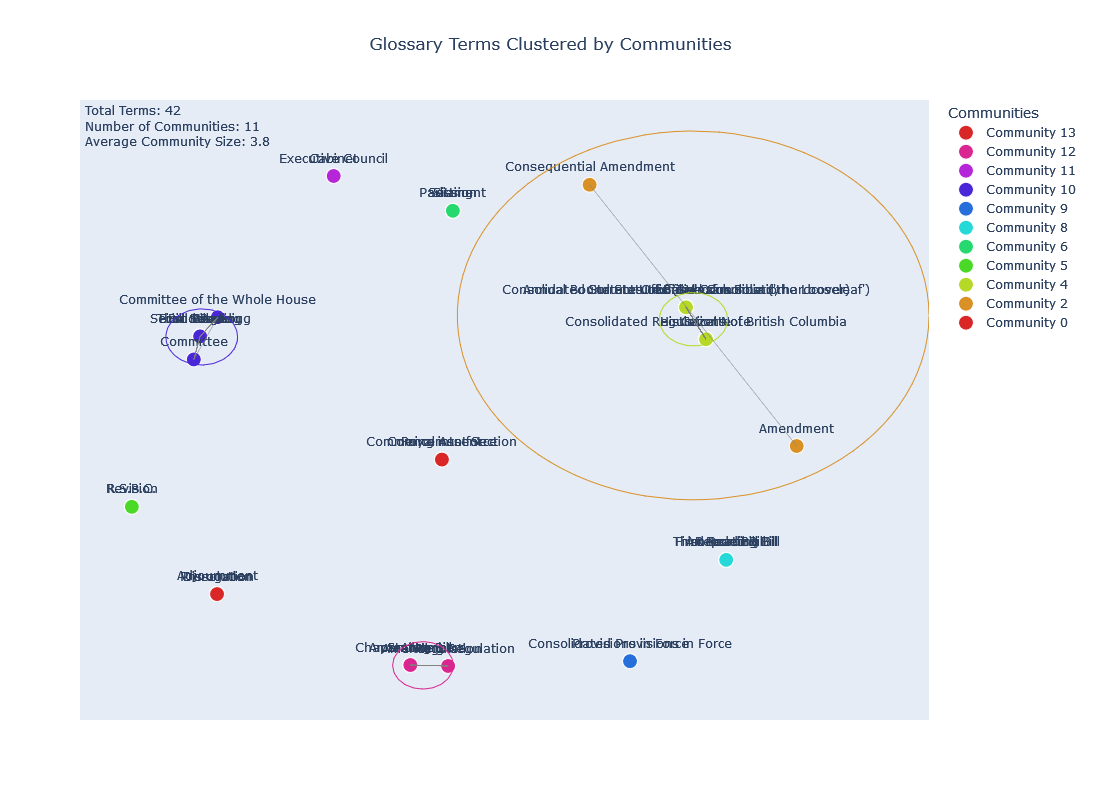


Community Overlap Analysis:
    Community1  Community2  Overlap_Count
4            4           4             28
5           10          10             21
0           12          12             15
2            8           8              6
1           13          13              3
7            0           0              3
9            6           6              3
3            2           2              1
6           11          11              1
8            9           9              1
10           5           5              1


In [126]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from sklearn.manifold import MDS
from sklearn.preprocessing import StandardScaler
import networkx as nx
from collections import defaultdict

def create_cluster_visualization(data, method='mds'):
    """
    Create an interactive cluster visualization of communities showing glossary terms
    
    Args:
        data: List of dictionaries containing community data
        method: Dimensionality reduction method ('mds' or 'custom')
    """
    df = pd.DataFrame(data)
    
    # Create a similarity matrix based on community membership
    def calculate_similarity(row1, row2):
        # Check final community similarity
        final_sim = 1 if row1['communityId'] == row2['communityId'] else 0
        # Check intermediate community similarity
        inter_sim = sum(i1 == i2 for i1, i2 in zip(row1['intermediateCommunityIds'], 
                                                  row2['intermediateCommunityIds'])) / len(row1['intermediateCommunityIds'])
        return (final_sim + inter_sim) / 2

    n = len(df)
    similarity_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            similarity_matrix[i,j] = calculate_similarity(df.iloc[i], df.iloc[j])
    
    # Convert similarity to distance
    distance_matrix = 1 - similarity_matrix
    
    # Use MDS to get 2D coordinates
    mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
    coords = mds.fit_transform(distance_matrix)
    
    # Create color mapping for communities
    unique_communities = sorted(df['communityId'].unique())
    colors = [f'hsl({h},70%,50%)' for h in np.linspace(0, 360, len(unique_communities))]
    color_map = dict(zip(unique_communities, colors))
    
    # Create hover text
    hover_text = []
    for idx, row in df.iterrows():
        intermediate_comms = ', '.join(map(str, row['intermediateCommunityIds']))
        text = f"Term: {row['name']}<br>" + \
               f"Final Community: {row['communityId']}<br>" + \
               f"Intermediate Communities: {intermediate_comms}"
        hover_text.append(text)
    
    # Create scatter plot for each community
    fig = go.Figure()
    
    # Add traces for each community
    for comm in unique_communities:
        mask = df['communityId'] == comm
        
        # Add nodes
        fig.add_trace(go.Scatter(
            x=coords[mask, 0],
            y=coords[mask, 1],
            mode='markers+text',
            name=f'Community {comm}',
            text=df[mask]['name'],
            hovertext=[hover_text[i] for i, m in enumerate(mask) if m],
            hoverinfo='text',
            textposition="top center",
            marker=dict(
                size=15,
                color=color_map[comm],
                line=dict(width=1, color='white')
            )
        ))
        
        # Add a transparent circle encompassing the community
        comm_coords = coords[mask]
        if len(comm_coords) > 0:
            center = comm_coords.mean(axis=0)
            radius = np.max(np.linalg.norm(comm_coords - center, axis=1)) * 1.2
            
            theta = np.linspace(0, 2*np.pi, 100)
            circle_x = center[0] + radius * np.cos(theta)
            circle_y = center[1] + radius * np.sin(theta)
            
            fig.add_trace(go.Scatter(
                x=circle_x,
                y=circle_y,
                mode='lines',
                name=f'Community {comm} boundary',
                line=dict(color=color_map[comm], width=1),
                fill='tonexty',
                fillcolor=color_map[comm].replace('50%', '20%'),  # More transparent
                showlegend=False,
                hoverinfo='skip'
            ))
    
    # Add edges between terms that share intermediate communities
    for i in range(len(df)):
        for j in range(i+1, len(df)):
            if any(x == y for x, y in zip(df.iloc[i]['intermediateCommunityIds'], 
                                        df.iloc[j]['intermediateCommunityIds'])):
                fig.add_trace(go.Scatter(
                    x=[coords[i,0], coords[j,0]],
                    y=[coords[i,1], coords[j,1]],
                    mode='lines',
                    line=dict(color='gray', width=0.5),
                    showlegend=False,
                    hoverinfo='skip'
                ))
    
    # Update layout
    fig.update_layout(
        title="Glossary Terms Clustered by Communities",
        title_x=0.5,
        showlegend=True,
        legend_title="Communities",
        width=1000,
        height=800,
        hovermode='closest',
        xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)
    )
    
    # Add summary annotations
    summary_text = f"Total Terms: {len(df)}<br>" + \
                  f"Number of Communities: {len(unique_communities)}<br>" + \
                  f"Average Community Size: {len(df)/len(unique_communities):.1f}"
    
    fig.add_annotation(
        text=summary_text,
        xref="paper", yref="paper",
        x=0, y=1,
        showarrow=False,
        font=dict(size=12),
        align="left"
    )
    
    return fig

def analyze_community_relationships(data):
    """
    Analyze and return statistics about community relationships
    """
    df = pd.DataFrame(data)
    
    # Calculate community overlap statistics
    overlaps = defaultdict(int)
    for i in range(len(df)):
        for j in range(i+1, len(df)):
            row1, row2 = df.iloc[i], df.iloc[j]
            if any(x == y for x, y in zip(row1['intermediateCommunityIds'], 
                                        row2['intermediateCommunityIds'])):
                key = tuple(sorted([row1['communityId'], row2['communityId']]))
                overlaps[key] += 1
    
    # Create summary DataFrame
    overlap_df = pd.DataFrame([
        {'Community1': k[0], 
         'Community2': k[1], 
         'Overlap_Count': v}
        for k, v in overlaps.items()
    ])
    
    return overlap_df

# Example usage:
fig = create_cluster_visualization(data)
fig.show()

# Print community relationship analysis
overlap_df = analyze_community_relationships(data)
print("\nCommunity Overlap Analysis:")
print(overlap_df.sort_values('Overlap_Count', ascending=False))